In [110]:
import numpy as np
import torch
from matplotlib import pyplot as plt 
import os
import cv2
from patchify import patchify
from PIL import Image
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
import pandas as pd

### Loading Data 

In [111]:
root_directory = "Semantic segmentation dataset"
patch_size = 256
scaler = MinMaxScaler()

image_dataset = []
for path, subdirs, files in os.walk(root_directory):
    #print(path)
    dirname= path.split(os.path.sep)[-1]
    if dirname == "images":
        images = os.listdir(path)
     #   print(images)
        for i, image_name in enumerate(images):
            if image_name.endswith(".jpg"):
                image = cv2.imread(path+os.path.sep+image_name,cv2.IMREAD_COLOR)
                image_before_crop = image
                image_before_crop = Image.fromarray(image_before_crop)
                SIZE_X = (image.shape[1]//patch_size)*patch_size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size
                image = Image.fromarray(image)
                image_after_crop = image.crop((0,0,SIZE_X,SIZE_Y))
                image = np.array(image_after_crop)

                #Extract patches from each image
                print("Now patchifying image: ",path,"/",image_name)
                patches_img = patchify(image, (patch_size,patch_size,3),step=256)

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        single_patch_img = patches_img[i,j,:,:].squeeze()
                        #print(single_patch_img.shape[-1])
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        image_dataset.append(single_patch_img)

Now patchifying image:  Semantic segmentation dataset\Tile 1\images / image_part_001.jpg
Now patchifying image:  Semantic segmentation dataset\Tile 1\images / image_part_002.jpg
Now patchifying image:  Semantic segmentation dataset\Tile 1\images / image_part_003.jpg
Now patchifying image:  Semantic segmentation dataset\Tile 1\images / image_part_004.jpg
Now patchifying image:  Semantic segmentation dataset\Tile 1\images / image_part_005.jpg
Now patchifying image:  Semantic segmentation dataset\Tile 1\images / image_part_006.jpg
Now patchifying image:  Semantic segmentation dataset\Tile 1\images / image_part_007.jpg
Now patchifying image:  Semantic segmentation dataset\Tile 1\images / image_part_008.jpg
Now patchifying image:  Semantic segmentation dataset\Tile 1\images / image_part_009.jpg
Now patchifying image:  Semantic segmentation dataset\Tile 2\images / image_part_001.jpg
Now patchifying image:  Semantic segmentation dataset\Tile 2\images / image_part_002.jpg
Now patchifying image

Mask Dataset

In [112]:
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 

Now patchifying mask: Semantic segmentation dataset\Tile 1\masks/image_part_001.png
Now patchifying mask: Semantic segmentation dataset\Tile 1\masks/image_part_002.png
Now patchifying mask: Semantic segmentation dataset\Tile 1\masks/image_part_003.png
Now patchifying mask: Semantic segmentation dataset\Tile 1\masks/image_part_004.png
Now patchifying mask: Semantic segmentation dataset\Tile 1\masks/image_part_005.png
Now patchifying mask: Semantic segmentation dataset\Tile 1\masks/image_part_006.png
Now patchifying mask: Semantic segmentation dataset\Tile 1\masks/image_part_007.png
Now patchifying mask: Semantic segmentation dataset\Tile 1\masks/image_part_008.png
Now patchifying mask: Semantic segmentation dataset\Tile 1\masks/image_part_009.png
Now patchifying mask: Semantic segmentation dataset\Tile 2\masks/image_part_001.png
Now patchifying mask: Semantic segmentation dataset\Tile 2\masks/image_part_002.png
Now patchifying mask: Semantic segmentation dataset\Tile 2\masks/image_part_

In [113]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)
image_dataset.shape,mask_dataset.shape

((1305, 256, 256, 3), (1305, 256, 256, 3))

Image Generation for Chechk

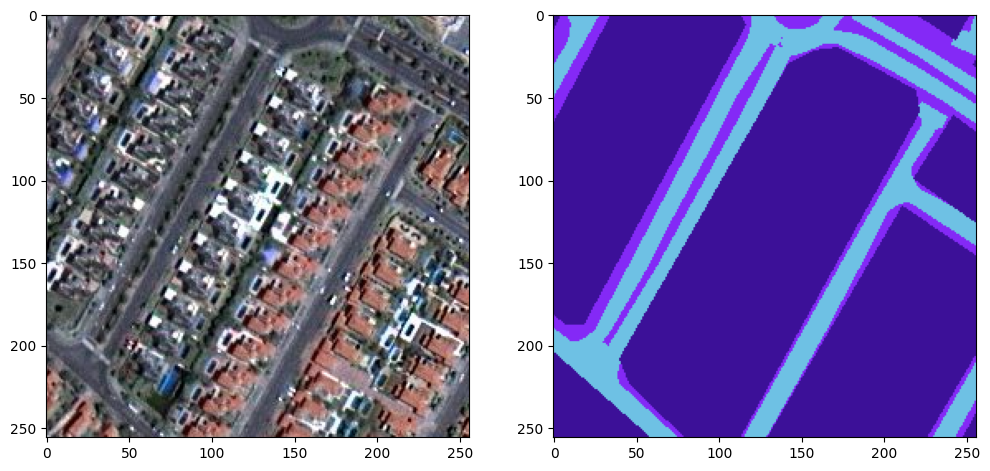

In [114]:
import random
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
print()
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

Pathcing

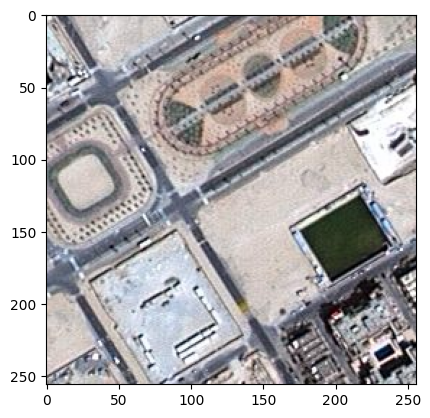

In [115]:
patches_img
plt.imshow(patches_img[2,1].squeeze())

Crop

Text(0.5, 1.0, 'Image After Crop')

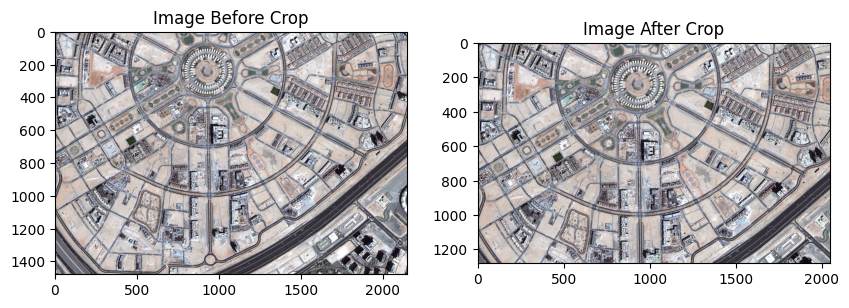

In [116]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(image_before_crop)
plt.title("Image Before Crop")
plt.subplot(1,2,2)
plt.imshow(image_after_crop)
plt.title("Image After Crop")

### Calculating RGB from HEX: #3C1098

    R = 201/16 = 12 with remainder of 9. So hex dode for R is C9 (remember C=12)

    3C = 3*16 + 12 = 60
    10 = 1*16 + 0 = 16
    90 = 9*16 + 8 = 152


    Building: #3C1098
    Land (unpaved area): #8429F6
    Road: #6EC1E4
    Vegetation: #FEDD3A
    Water: #E2A929
    Unlabeled: #9B9B9B

In [117]:
a = int("3C",16) #3C with base 15. Should return 60.
a

60

In [118]:
Building = "#3C1098".lstrip("#")
temp_list = []
for i in (0,2,4):
    temp_list.append(int(Building[i:i+2],16))
Building = np.array(temp_list)
temp_list.clear()

Land = "#8429F6".lstrip("#")
temp_list = []
for i in (0,2,4):
    temp_list.append(int(Land[i:i+2],16))
Land = np.array(temp_list)
temp_list.clear()

Road = "#6EC1E4".lstrip("#")
temp_list = []
for i in (0,2,4):
    temp_list.append(int(Road[i:i+2],16))
Road = np.array(temp_list)
temp_list.clear()

Vegetation = "#FEDD3A".lstrip("#")
temp_list = []
for i in (0,2,4):
    temp_list.append(int(Vegetation[i:i+2],16))
Vegetation = np.array(temp_list)
temp_list.clear()

Water = "#E2A929".lstrip("#")
temp_list = []
for i in (0,2,4):
    temp_list.append(int(Water[i:i+2],16))
Water = np.array(temp_list)
temp_list.clear()

Unlabeled = "#9B9B9B".lstrip("#")
temp_list = []
for i in (0,2,4):
    temp_list.append(int(Unlabeled[i:i+2],16))
Unlabeled = np.array(temp_list)
temp_list.clear()


In [119]:
Building,Land,Road,Vegetation,Water,Unlabeled

(array([ 60,  16, 152]),
 array([132,  41, 246]),
 array([110, 193, 228]),
 array([254, 221,  58]),
 array([226, 169,  41]),
 array([155, 155, 155]))

In [120]:
label = single_patch_mask
print("Color values of single patch mask : \n",label[2])

Color values of single patch mask : 
 [[110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [110 193 228]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [132  41 246]
 [

    Learn This Syntax
    Building = #3C1098'.lstrip('#')
    Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

In [121]:
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label==Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

In [122]:
label[1]

array([[110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [132,  41, 246],
       [132,  41, 246],
       [132,  41, 246],
       [132,  41, 246],
       [132,  41, 246],
       [132,  41, 246],
       [132,  41, 246],
       [132,  41, 246],
       [132,  41, 246],
       [132,  41, 246],
       [132,  41, 246],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193, 228],
       [110, 193

In [123]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)  
print(labels) 
labels = np.expand_dims(labels, axis=3)
 

print("Unique labels in label dataset are: ", np.unique(labels))

[[[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 [[1 5 5 ... 4 4 4]
  [1 5 5 ... 4 4 4]
  [1 1 5 ... 4 4 4]
  ...
  [1 1 1 ... 2 2 2]
  [1 1 1 ... 2 2 2]
  [1 1 1 ... 2 2 2]]

 [[4 4 4 ... 1 1 1]
  [4 4 4 ... 1 1 1]
  [4 4 4 ... 1 1 1]
  ...
  [2 2 2 ... 1 1 1]
  [2 2 2 ... 1 1 1]
  [2 2 2 ... 1 1 1]]

 ...

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 [[1 1 1 ... 2 2 2]
  [1 1 1 ... 2 2 2]
  [1 1 1 ... 2 2 2]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 [[2 2 2 ... 1 1 1]
  [2 2 2 ... 1 1 1]
  [2 2 2 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]]
Unique labels in label dataset are:  [0 1 2 3 4 5]


In [124]:
labels.flatten().reshape(-1,1)

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=uint8)

OneHotEncoding

In [125]:
ohe = OneHotEncoder(sparse_output=False)
encoded_labels = ohe.fit_transform(labels.flatten().reshape(-1,1))
encoded_labels = encoded_labels.reshape((1305,256,256,6))

In [126]:
encoded_labels

array([[[[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         ...,
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         ...,
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         ...,
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]],

        ...,

        [[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         ...,
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0.